# Final Project - SP 

<div style="padding:10px; border:1px solid #526074ff; background:#526074ff; border-radius:8px;">
<strong>Group ID:</strong> A<br>
<strong>Group Members:</strong> Navdeep Kaur, Laia Fortuny Parull, Marco Russo, Yudi Wang Zhang, Raians Sprogis Marons, José Pablo Soriano Torres, and Christian Dorado Cerrato
</div>


### Description of the project 
The project uses the Chronic Kidney Disease (CKD) dataset to build a machine learning model that predicts whether a patient has CKD or not. The dataset contains clinical and laboratory features with missing values, which are cleaned and processed before training and evaluating the model. The final model is deployed as an API that takes patient data as input and returns a diagnostic prediction.

In [32]:
#Necessary imports for data manipulation and visualization

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

In [33]:
%matplotlib inline


#### **Step 1**: Data Loading and Understanding

In [34]:
#Define the path to the text file
path = "../../data/raw/chronic_kidney_disease_info.txt"

#Read and print the contents of the text file
with open(path, "r", encoding="utf-8") as f:
    text = f.read()

print(text)

% 1. Title: Early stage of Indians Chronic Kidney Disease(CKD)
%
% 2. Source Information:
%   (a) Source: 
			Dr.P.Soundarapandian.M.D.,D.M
			(Senior Consultant Nephrologist), 
			Apollo  Hospitals, 
			Managiri,
			Madurai Main Road, 
			Karaikudi,
			Tamilnadu,
			India.

%   (b) Creator: 
			L.Jerlin Rubini(Research Scholar)
			Alagappa University,
			EmailId   :jel.jerlin@gmail.com
			ContactNo :+91-9597231281

%   (c) Guided by: 
			Dr.P.Eswaran Assistant Professor,
			Department of Computer Science and Engineering,
			Alagappa University,
			Karaikudi,
			Tamilnadu,
			India.
			Emailid:eswaranperumal@gmail.com

%   (d) Date     : July 2015
%
% 3.Relevant Information:
			age		-	age	
			bp		-	blood pressure
			sg		-	specific gravity
			al		-   	albumin
			su		-	sugar
			rbc		-	red blood cells
			pc		-	pus cell
			pcc		-	pus cell clumps
			ba		-	bacteria
			bgr		-	blood glucose random
			bu		-	blood urea
			sc		-	serum creatinine
			sod		-	sodium
			pot		-	potassium
			hemo		-	hem

The text file contains information regarding the dataset. It explains what each column means, which values are allowed, how missing data is marked (“?”), and how many CKD vs non-CKD cases are included.


In [35]:
#Define the path to the dataset
path = "../../data/raw/chronic_kindey_disease.csv"
#Load the dataset into a pandas DataFrame
df = pd.read_csv(path) 

df.shape, df.columns

((400, 25),
 Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
        'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
        'appet', 'pe', 'ane', 'status'],
       dtype='object'))

From df.shape = (400, 25), our dataset has 400 rows (instances) and 25 columns (that's 24 predictors + 1 target column status).

In [36]:
#Preview of the first 10 rows of the dataset
df.head(10)


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,status
0,48.0,80.0,1.02,1.0,0.0,?,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.02,4.0,0.0,?,normal,notpresent,notpresent,?,...,38.0,6000.0,?,no,no,no,good,no,no,ckd
2,62.0,80.0,1.01,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,?,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.01,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd
5,60.0,90.0,1.015,3.0,0.0,?,?,notpresent,notpresent,74.0,...,39.0,7800.0,4.4,yes,yes,no,good,yes,no,ckd
6,68.0,70.0,1.01,0.0,0.0,?,normal,notpresent,notpresent,100.0,...,36.0,?,?,no,no,no,good,no,no,ckd
7,24.0,?,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,410.0,...,44.0,6900.0,5.0,no,yes,no,good,yes,no,ckd
8,52.0,100.0,1.015,3.0,0.0,normal,abnormal,present,notpresent,138.0,...,33.0,9600.0,4.0,yes,yes,no,good,no,yes,ckd
9,53.0,90.0,1.02,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,ckd


In [37]:
#Get summary statistics of the DataFrame
df.describe() 

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,status
count,400,400,400,400,400,400,400,400,400,400,...,400,400,400,400,400,400,400,400,400,400
unique,77,11,6,7,7,3,3,3,3,147,...,43,90,46,3,4,3,3,3,3,3
top,60.0,80.0,1.02,0.0,0.0,normal,normal,notpresent,notpresent,?,...,?,?,?,no,no,no,good,no,no,ckd
freq,19,116,106,199,290,201,259,354,374,44,...,71,106,131,251,260,364,317,323,339,248


status
ckd       250
notckd    150
Name: count, dtype: int64


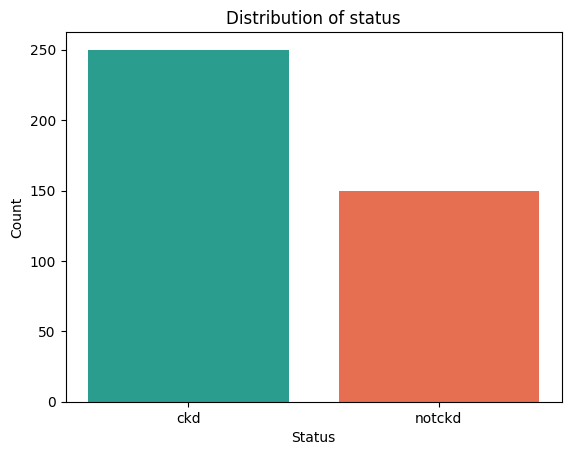

In [38]:
#Visualize the distribution of the "status" column

df["status"] = df["status"].astype(str).str.strip()

counts = df["status"].value_counts()
print(counts)
counts = counts.reindex(["ckd", "notckd"])  # consistent order
colors = ["#2a9d8f", "#e76f51"]  # teal + coral

plt.figure()
plt.bar(counts.index, counts.values, color=colors)
plt.xlabel("Status")
plt.ylabel("Count")
plt.title("Distribution of status")
plt.show()



Out of 400 individuals, 250 (62.5%) are labeled ckd and 150 (37.5%) are labeled notckd. We can consider the class distribution to be moderately imbalanced

In [39]:
#Since we loaded df without specifying na_values we will replace "?" with actual NaN

#Replace "?" with NaN
df_missing = df.replace("?", np.nan)

#Missing counts per column (only columns with missing)
missing_counts = df_missing.isna().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

#Convert columns to numeric where possible (without forcing)
df_coerced = df_missing.copy()
for col in df_coerced.columns:
    df_coerced[col] = pd.to_numeric(df_coerced[col], errors="ignore")

#Identify numeric vs categorical among columns that have missing values
numeric_cols = [c for c in missing_counts.index if pd.api.types.is_numeric_dtype(df_coerced[c])]
categorical_cols = [c for c in missing_counts.index if not pd.api.types.is_numeric_dtype(df_coerced[c])]

print("Numeric columns with missing values:")
for c in numeric_cols:
    print(f"  {c}: {int(missing_counts[c])}")

print("\nCategorical columns with missing values:")
for c in categorical_cols:
    print(f"  {c}: {int(missing_counts[c])}")

Numeric columns with missing values:
  rbcc: 131
  wbcc: 106
  pot: 88
  sod: 87
  pcv: 71
  hemo: 52
  su: 49
  sg: 47
  al: 46
  bgr: 44
  bu: 19
  sc: 17
  bp: 12
  age: 9

Categorical columns with missing values:
  rbc: 152
  pc: 65
  pcc: 4
  ba: 4
  htn: 2
  dm: 2
  cad: 2
  appet: 1
  pe: 1
  ane: 1


C:\Users\Usuario\AppData\Local\Temp\ipykernel_7448\3661303729.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_coerced[col] = pd.to_numeric(df_coerced[col], errors="ignore")


After converting "?" to NaN, we find 1012 missing values in total. Missingness affects 14 numeric and 10 categorical variables. Among the numeric features, the highest missing counts occur in 
- **red blood cell count (rbcc, 131)** 
- **white blood cell count (wbcc, 106)**
- **potassium (pot, 88)**
- **sodium (sod, 87)**
- **packed cell volume (pcv, 71)**
- **hemoglobin (hemo, 52)**
- **sugar (su, 49)**
- **specific gravity (sg, 47)**
- **albumin (al, 46)**
- **random blood glucose (bgr, 44)**
- **blood urea (bu, 19)**
- **serum creatinine (sc, 17)**
- **blood pressure (bp, 12)**
- **age (age, 9)**

For categorical variables, missingness is mainly concentrated in 
- **red blood cells (rbc, 152)**
- **pus cell (pc, 65)**
- **pus cell clumps (pcc, 4)**
- **bacteria (ba, 4)**
- **hypertension (htn, 2)**
- **diabetes mellitus (dm, 2)**
- **coronary artery disease (cad, 2)**
- **appetite (appet, 1)**
- **pedal edema (pe, 1)**
- **anemia (ane, 1)**.


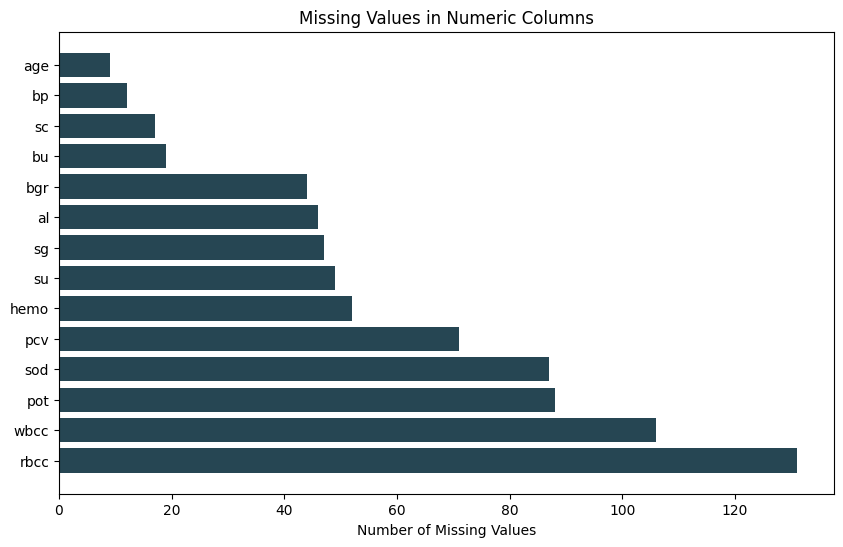

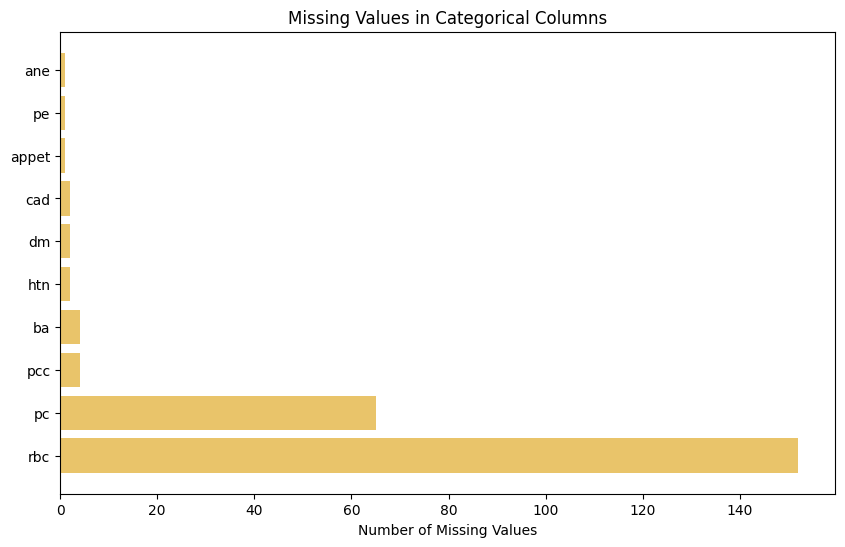

In [41]:
#Let's visualize the missing data for numeric columns
plt.figure(figsize=(10, 6))
plt.barh(numeric_cols, [missing_counts[c] for c in numeric_cols], color="#264653")
plt.xlabel("Number of Missing Values")
plt.title("Missing Values in Numeric Columns")
plt.show()
#And for categorical columns
plt.figure(figsize=(10, 6))
plt.barh(categorical_cols, [missing_counts[c] for c in categorical_cols], color
="#e9c46a")
plt.xlabel("Number of Missing Values")
plt.title("Missing Values in Categorical Columns")
plt.show()

In [43]:
#Data Cleaning Steps
# 1) Clean status (this dataset often has trailing spaces/tabs)
df["status"] = df["status"].astype(str).str.strip()

# 2) Replace "?" with NaN (without touching the original file)
df_missing = df.replace("?", np.nan)


In [44]:
#Overall missing values summary
missing_counts = df_missing.isna().sum().sort_values(ascending=False)
missing_rates = (df_missing.isna().mean() * 100).sort_values(ascending=False)

summary = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_%": missing_rates.round(2)
})

summary = summary[summary["missing_count"] > 0]
summary.head(20)


,missing_count,missing_%
rbc,152,38.00
rbcc,131,32.75
wbcc,106,26.50
pot,88,22.00
sod,87,21.75
pcv,71,17.75
pc,65,16.25
hemo,52,13.00
su,49,12.25
sg,47,11.75


In [46]:
#Missingness by status (CKD vs notCKD): This tells us if a column is missing more in one class than the other.
# Missing % per column within each class
miss_by_class = (
    df_missing.isna()
    .groupby(df_missing["status"])
    .mean()
    .T * 100
)

# Keep only columns that have any missing values
miss_by_class = miss_by_class.loc[summary.index]

# Add a "gap" column (absolute difference between classes)
# (works even if order is not exactly ckd/notckd)
cols = miss_by_class.columns.tolist()
if len(cols) == 2:
    miss_by_class["gap_%"] = (miss_by_class[cols[0]] - miss_by_class[cols[1]]).abs()

miss_by_class.sort_values("gap_%" if "gap_%" in miss_by_class.columns else cols[0], ascending=False).head(20)


status,ckd,notckd,gap_%
rbc,57.2,6.000000,51.200000
rbcc,49.6,4.666667,44.933333
wbcc,39.6,4.666667,34.933333
pot,33.2,3.333333,29.866667
sod,32.8,3.333333,29.466667
pcv,26.8,2.666667,24.133333
pc,22.4,6.000000,16.400000
hemo,18.4,4.000000,14.400000
su,17.6,3.333333,14.266667
sg,16.8,3.333333,13.466667


From the previous table we can infer that missingness is not random. It is systematically higher in the CKD group for many variables. 

In [47]:
# Data Cleaning Steps 

#Keep the original exactly as loaded (untouched)
df_original = df.copy(deep=True)

# Work on a separate copy only
df_work = df_original.copy(deep=True)

# Convert "?" to real missing values (NaN) in the working copy
df_work = df_work.replace("?", np.nan)

# Clean status spacing (common issue)
df_work["status"] = df_work["status"].astype(str).str.strip()


In [48]:
# Define the categorical columns that have missing values
cat_missing_cols = ["rbc","pc","pcc","ba","htn","dm","cad","appet","pe","ane"]


Choose an imputation strategy

Because missingness is very different in CKD vs notCKD (not missing at random), a strong default is:

- For high-missing categorical variables (like rbc, pc): fill with an explicit label "missing" so the model can learn that missingness itself is informative.
- For low-missing categorical variables (1-4 missing values): fill with the mode (most frequent category), since a “missing” category for 1 value usually adds noise.We can automate that with a threshold (e.g., 5%).

In [53]:
# CATEGORICAL missing value imputation

# 1) MODE imputation for low-missing categorical columns (everything except rbc, pc)
low_missing_cols = ["pcc","ba","htn","dm","cad","appet","pe","ane"]

for c in low_missing_cols:
    mode_val = df_work[c].mode(dropna=True).iloc[0]
    df_work[c] = df_work[c].fillna(mode_val)


In [55]:
print(df_work[cat_missing_cols].isna().sum())

rbc      152
pc        65
pcc        0
ba         0
htn        0
dm         0
cad        0
appet      0
pe         0
ane        0
dtype: int64


In [ ]:
for c in ["rbc", "pc"]:
    #keep a missingness flag anyway 
    df_work[c + "_missing"] = df_work[c].isna().astype(int)

    # fill NaN using the mode within each status group
    df_work[c] = df_work.groupby("status")[c].transform(
        lambda s: s.fillna(s.mode(dropna=True).iloc[0] if not s.mode(dropna=True).empty else s)
    )

# check remaining missing
print(df_work[cat_missing_cols].isna().sum())

rbc      0
pc       0
pcc      0
ba       0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
dtype: int64
